# Non-Local Means (NLM) Denoising for Gaussian and Rician Simulated Noisy Images

This Python script is designed to apply Non-Local Means Denoising to images affected by Gaussian noise across different Signal-to-Noise Ratios (SNRs). The Non-Local Means algorithm is particularly effective for preserving details in images while removing noise, making it suitable for applications where detail preservation is critical.

## Key Components of the Script

### Functions
- `create_background_mask(image_gray)`: Generates a binary mask for the largest contiguous region in the image, assumed to be the background. This is useful for isolating the area of interest in medical or biological images where background consistency is crucial.
- `adjust_denoising_parameters(sigma_est)`: Dynamically adjusts the denoising parameters based on the estimated noise standard deviation in the image. This ensures that the denoising strength is appropriate for the level of noise present.
- `estimate_sigma(noisy_image)`: Estimates the noise standard deviation from the noisy image, which is critical for setting the denoising strength correctly.

### Main Execution Flow
- **Data Loading**: The script loads a set of images with different SNRs and their corresponding ground truth images from MATLAB `.mat` files. This allows the denoising effectiveness to be evaluated against the true image data.
- **Image Processing**: For each image:
  - Converts to grayscale if it is a color image.
  - Estimates the noise level and adjusts denoising parameters accordingly.
  - Applies a background mask to focus denoising efforts on relevant image areas.
  - Uses the Non-Local Means algorithm to denoise the image.
- **Performance Metrics**: Calculates and logs metrics like Peak Signal-to-Noise Ratio (PSNR), Structural Similarity Index (SSIM), and Mean Squared Error (MSE) for each denoised image compared to the ground truth. These metrics help quantify the effectiveness of the denoising process.

### Visualization
- **Image Display**: The script generates plots that show both the original noisy image and the denoised image, alongside performance metrics. This visual feedback is crucial for assessing the denoising algorithm's effectiveness visually and numerically.




/var/folders/vl/tld4y4295dvbpfhgzk8mrvkc0000gn/T/ipykernel_47003/5379605.py:91: UserWarning: image is size 3 on the last axis, but channel_axis is None. If this is a color image, please set channel_axis=-1 for proper noise estimation.
  sigma_est = np.mean(estimate_sigma(noisy_image))


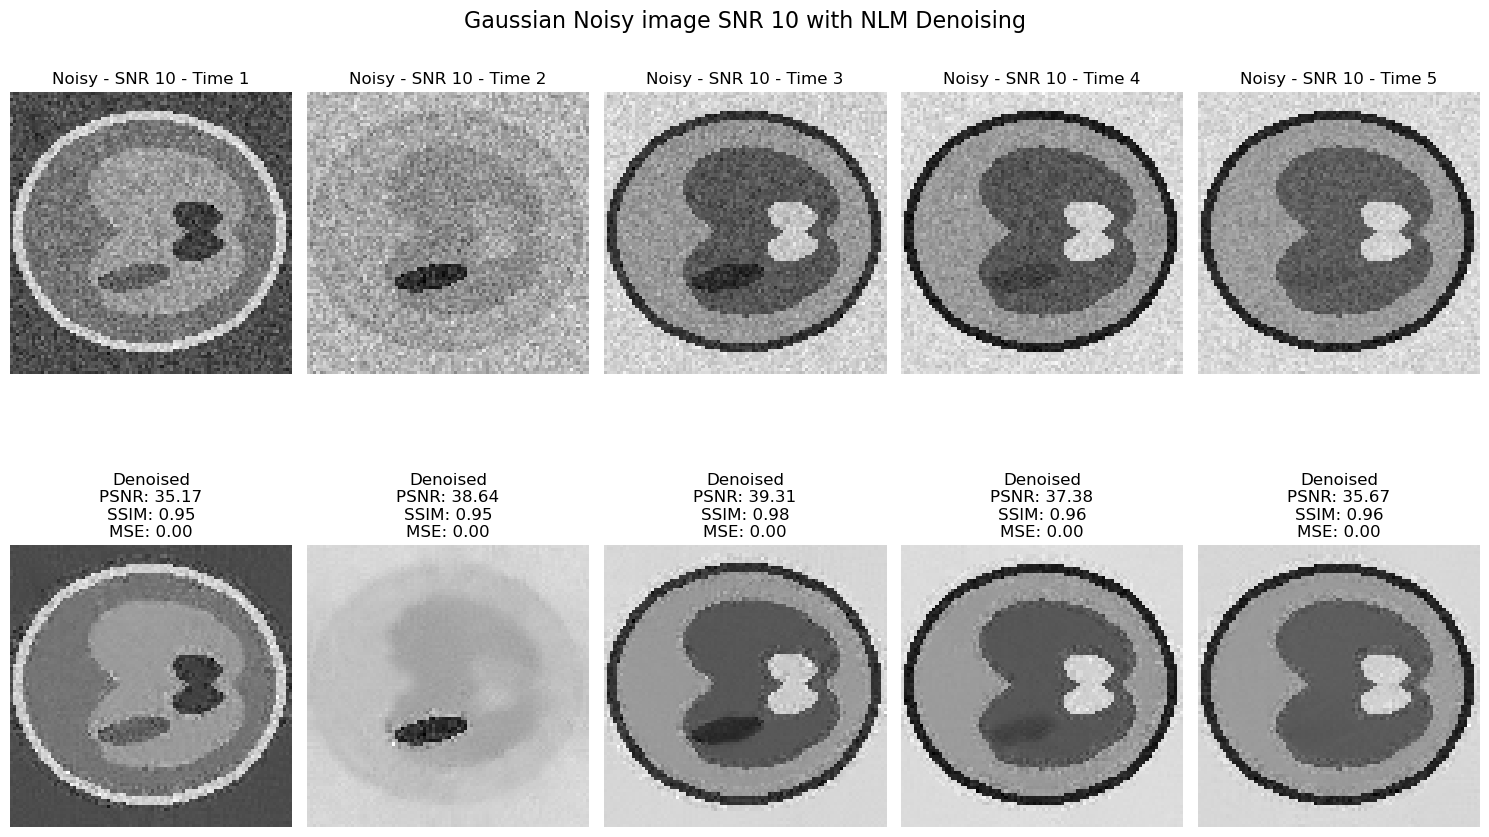

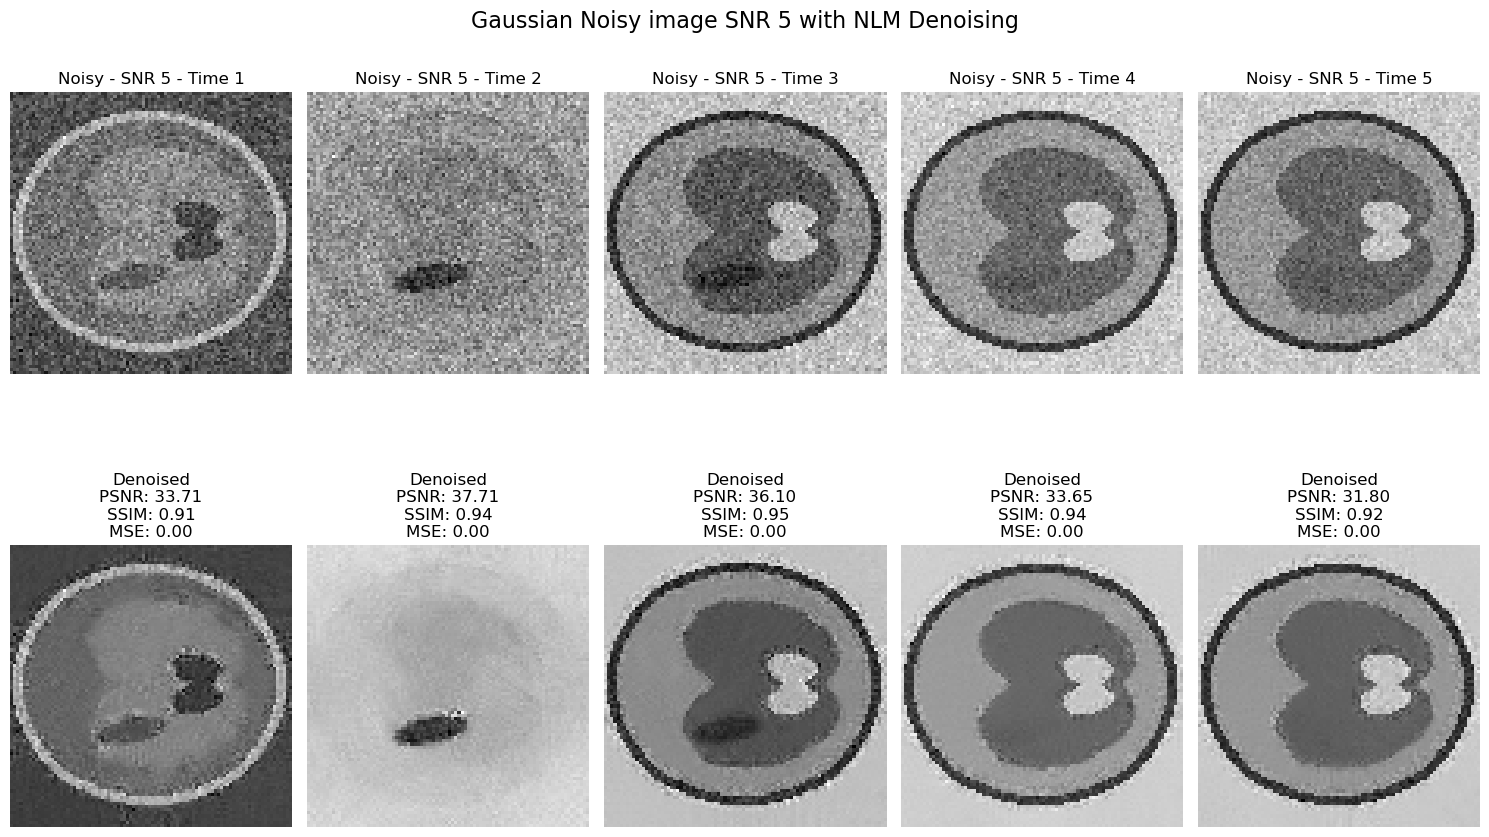

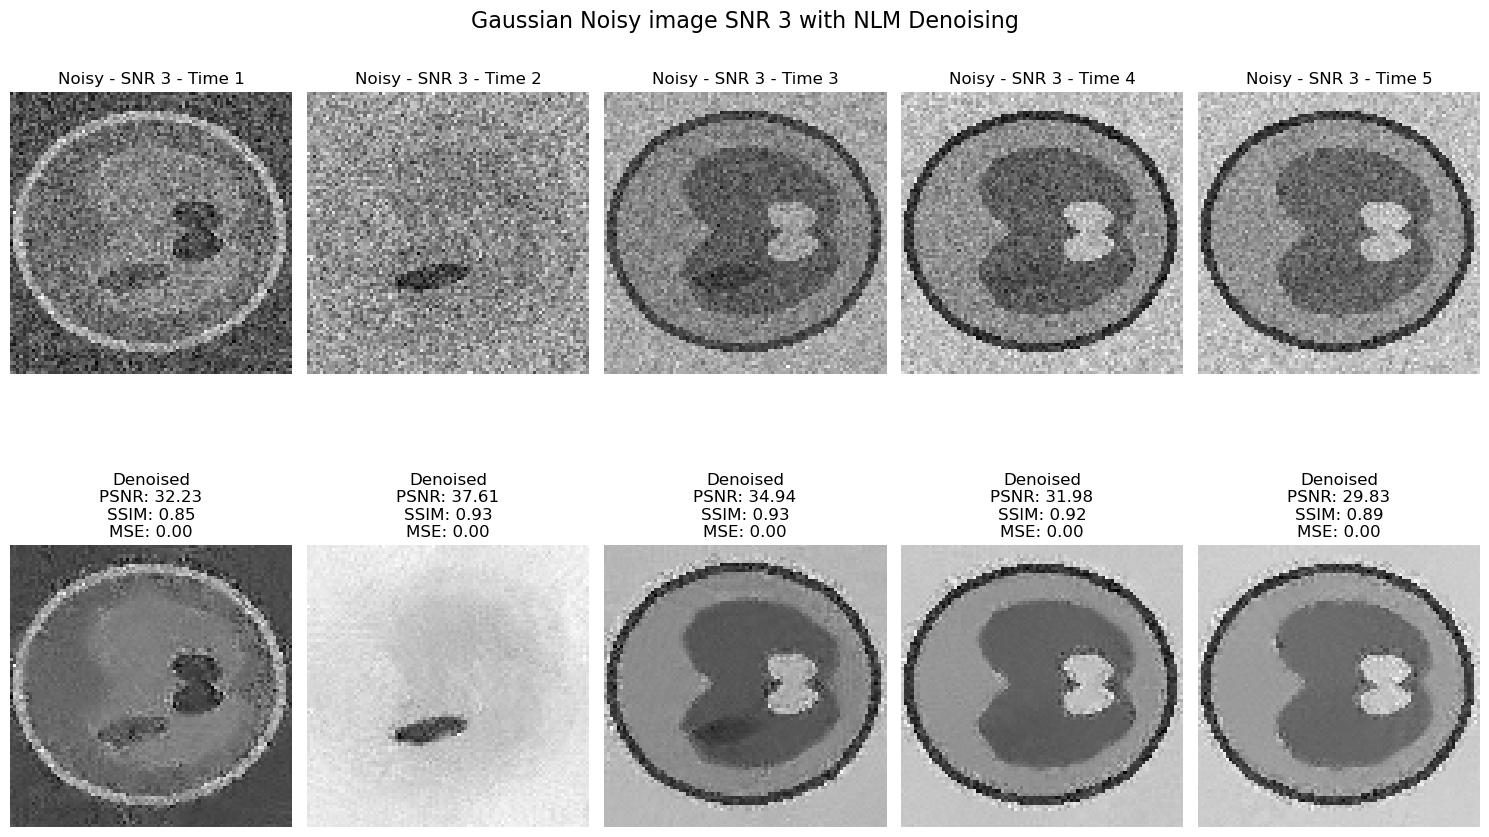

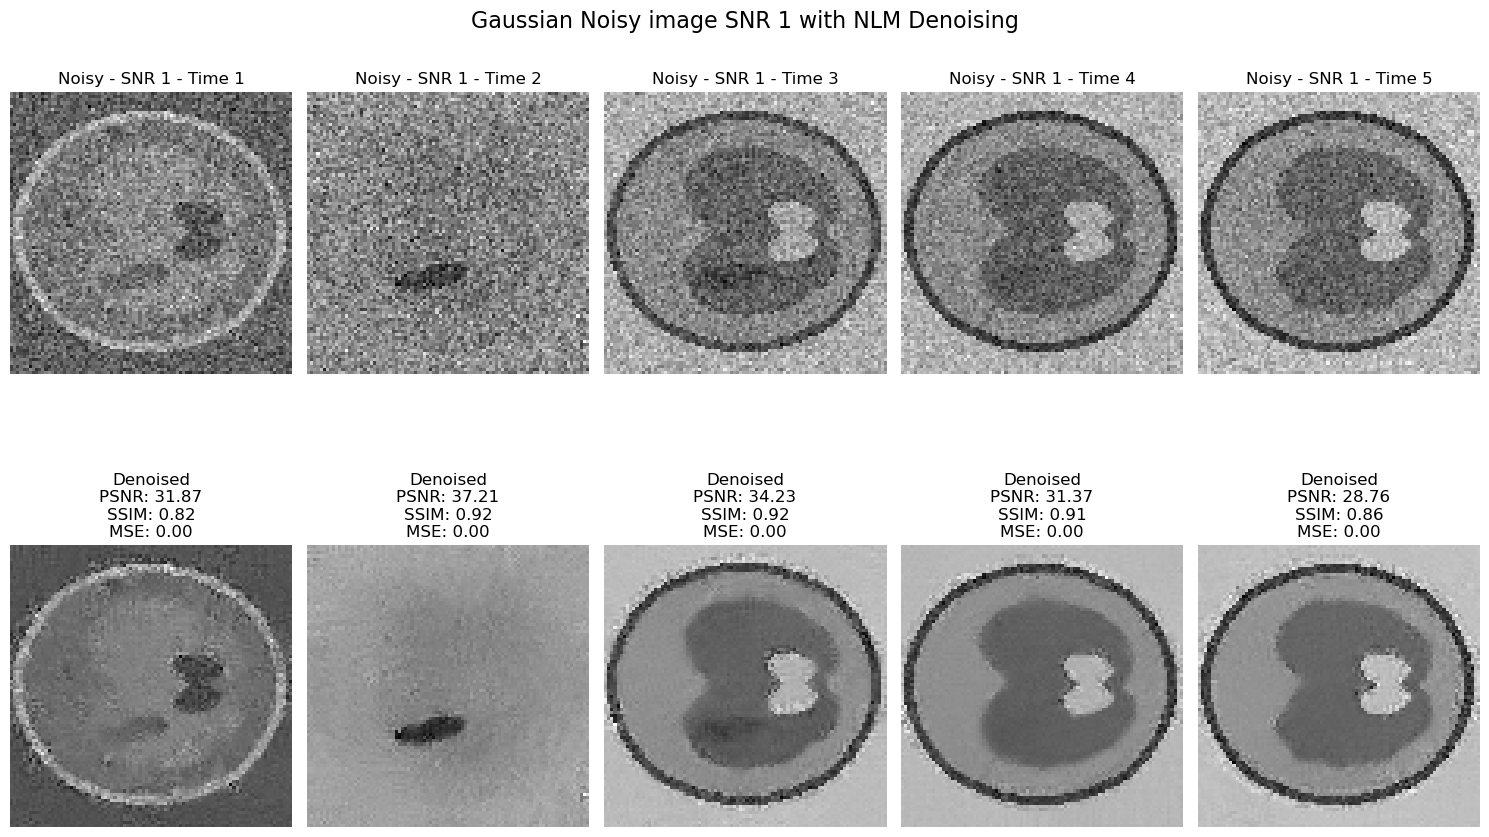

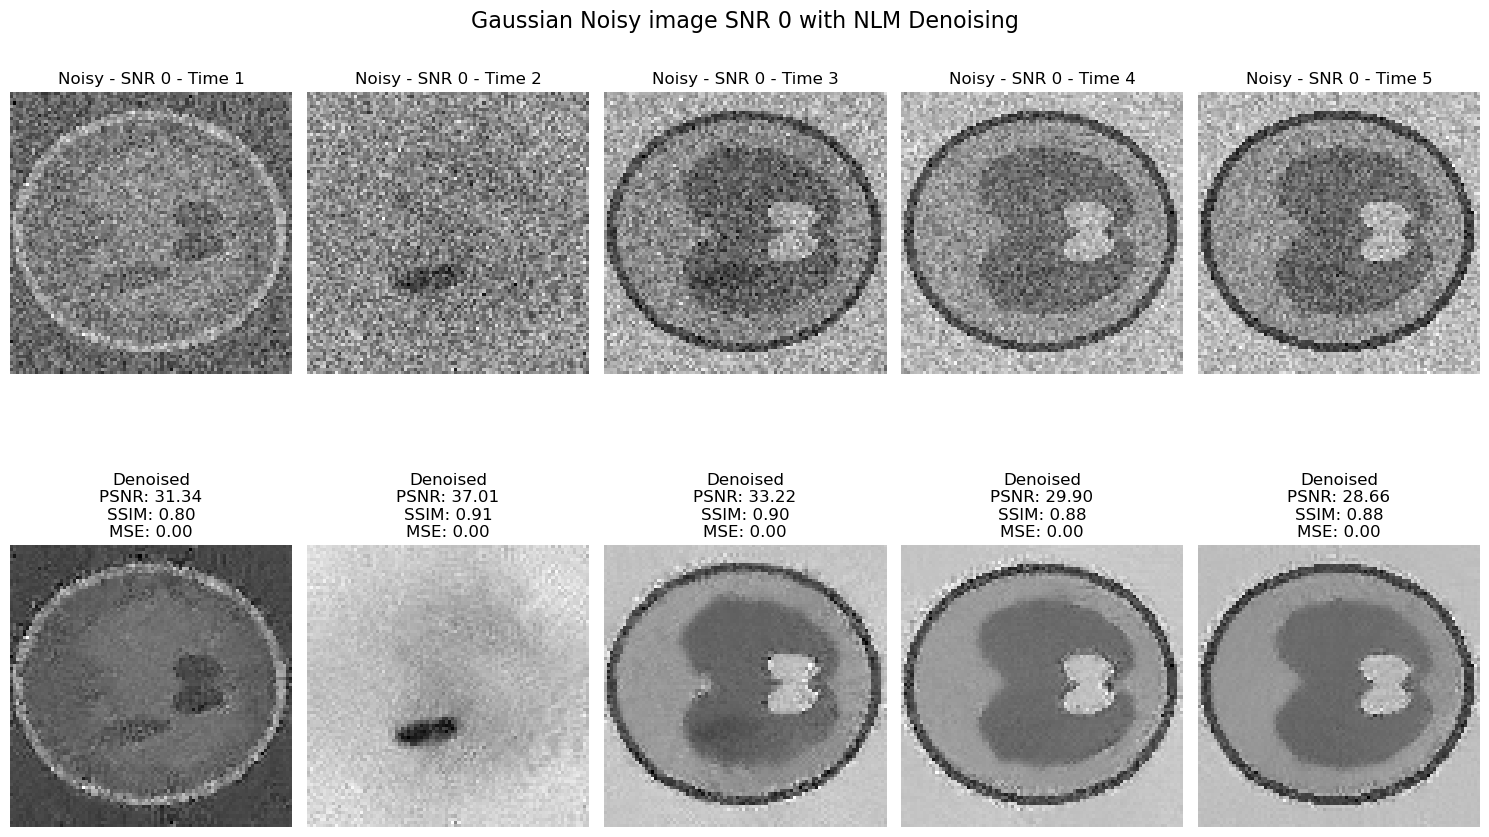

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.restoration import estimate_sigma, denoise_nl_means
from skimage.filters import threshold_otsu
from skimage.segmentation import clear_border
from skimage.measure import label, regionprops
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import mean_squared_error as mse
from skimage.color import rgb2gray
import scipy.io
import scipy.io


# Define the specific SNRs to display
snrs = [10, 5, 3, 1, 0]  

def create_background_mask(image_gray):
    # Use Otsu's method to automatically determine a threshold for binarization
    thresh = threshold_otsu(image_gray)

    # Binarize the image based on the determined threshold
    binary_image = image_gray <= thresh

    # Remove small objects and clear borders
    cleared_image = clear_border(binary_image)

    # Label connected components
    label_image = label(cleared_image)

    # Find properties of labeled regions
    regions = regionprops(label_image)

    # Find the largest region (assuming it's the background)
    largest_area = 0
    background_label = 0
    for region in regions:
        if region.area > largest_area:
            largest_area = region.area
            background_label = region.label

    # Create a mask for the background region
    background_mask = label_image == background_label

    return background_mask

def adjust_denoising_parameters(sigma_est):
    if sigma_est <= 15:
        return 0.6 * sigma_est, 7, 11  # h, patch_size, patch_distance
    elif sigma_est <= 30:
        return 0.9 * sigma_est, 5, 6
    elif sigma_est <= 50:
        return 0.2 * sigma_est, 9, 17
    else:
        return 0.4 * sigma_est, 11, 23



for snr in snrs:
 
    # Load the MAT file
    mat = scipy.io.loadmat(f'../../ImagesForExperimentation/SimulationMatlab/GroundTruth_gaussian_SNR{snr}.mat')
    mat_ground_truth = scipy.io.loadmat(f'../../ImagesForExperimentation/SimulationMatlab/GroundTruth.mat')

    ground_truth_data = mat_ground_truth['data']
    noisy_image_data = mat['data_gaussian']
    

    evol_time = noisy_image_data.shape[2]

    plt.figure(figsize=(15, 2 * evol_time)) 

    for j in range(evol_time):
        # Extract the noisy image for the jth condition.
        noisy_image = noisy_image_data[:, :, j].squeeze()
        ground_truth= ground_truth_data[:, :, j]
        
        
        # Check if the image has three channels (RGB), and convert to grayscale if so
        if noisy_image.ndim == 3 and noisy_image.shape[2] == 3:
            noisy_image_gray = noisy_image.mean(axis=2)
        else:
 
            noisy_image_gray = noisy_image

        # Estimate the noise standard deviation from the image
        sigma_est = np.mean(estimate_sigma(noisy_image))

        # Dynamically adjust denoising parameters based on estimated noise level
        h, patch_size, patch_distance = adjust_denoising_parameters(sigma_est)

        # Create a mask to isolate the background
        background_mask = create_background_mask(noisy_image_gray)

        # Calculate the standard deviation of background pixels
        std_deviation = np.std(noisy_image_gray[background_mask])
        
        ground_truth_gray = rgb2gray(ground_truth)

        # Apply Non-Local Means Denoising with dynamically adjusted parameters
        denoised_image = denoise_nl_means(noisy_image_gray, h=h, patch_size=patch_size,
                                          patch_distance=patch_distance)
        
        
 
    
        image_ssim = ssim(ground_truth_gray, denoised_image, data_range=1.0)
        image_psnr = psnr(ground_truth_gray, denoised_image)
        image_mse = mse(ground_truth_gray, denoised_image)
       

        plt.subplot(2, evol_time, j + 1)
        plt.imshow(noisy_image_gray, cmap='gray')
        plt.title(f'Noisy - SNR {snr} - Time {j+1}')
        plt.axis('off')

        plt.subplot(2, evol_time, evol_time + j + 1)
        plt.imshow(denoised_image, cmap='gray')
        plt.title(f'Denoised\nPSNR: {image_psnr:.2f}\nSSIM: {image_ssim:.2f}\nMSE: {image_mse:.2f}')
        plt.axis('off')

    plt.subplots_adjust(wspace=0.1, hspace=0.1)  
    plt.tight_layout()  
    plt.suptitle(f'Gaussian Noisy image SNR {snr} with NLM Denoising', fontsize=16, y=0.95)
    plt.show()



# This is our Ground Truth

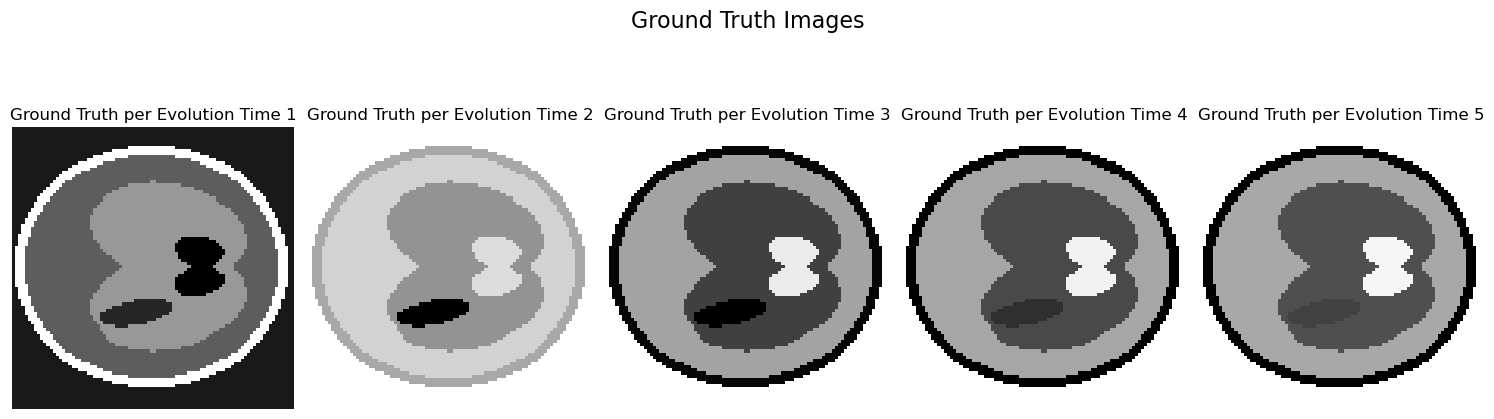

In [16]:
plt.figure(figsize=(15, 5)) 
for j in range(conditions):
    ground_truth = ground_truth_data[:, :, j]
    ground_truth_gray = rgb2gray(ground_truth) if ground_truth.ndim == 3 else ground_truth

    plt.subplot(1, conditions, j + 1)
    plt.imshow(ground_truth_gray, cmap='gray')
    plt.title(f'Ground Truth per Evolution Time {j+1}')
    plt.axis('off')

plt.suptitle('Ground Truth Images', fontsize=16)
plt.tight_layout()
plt.show()


/var/folders/vl/tld4y4295dvbpfhgzk8mrvkc0000gn/T/ipykernel_47003/145994079.py:91: UserWarning: image is size 3 on the last axis, but channel_axis is None. If this is a color image, please set channel_axis=-1 for proper noise estimation.
  sigma_est = np.mean(estimate_sigma(noisy_image))


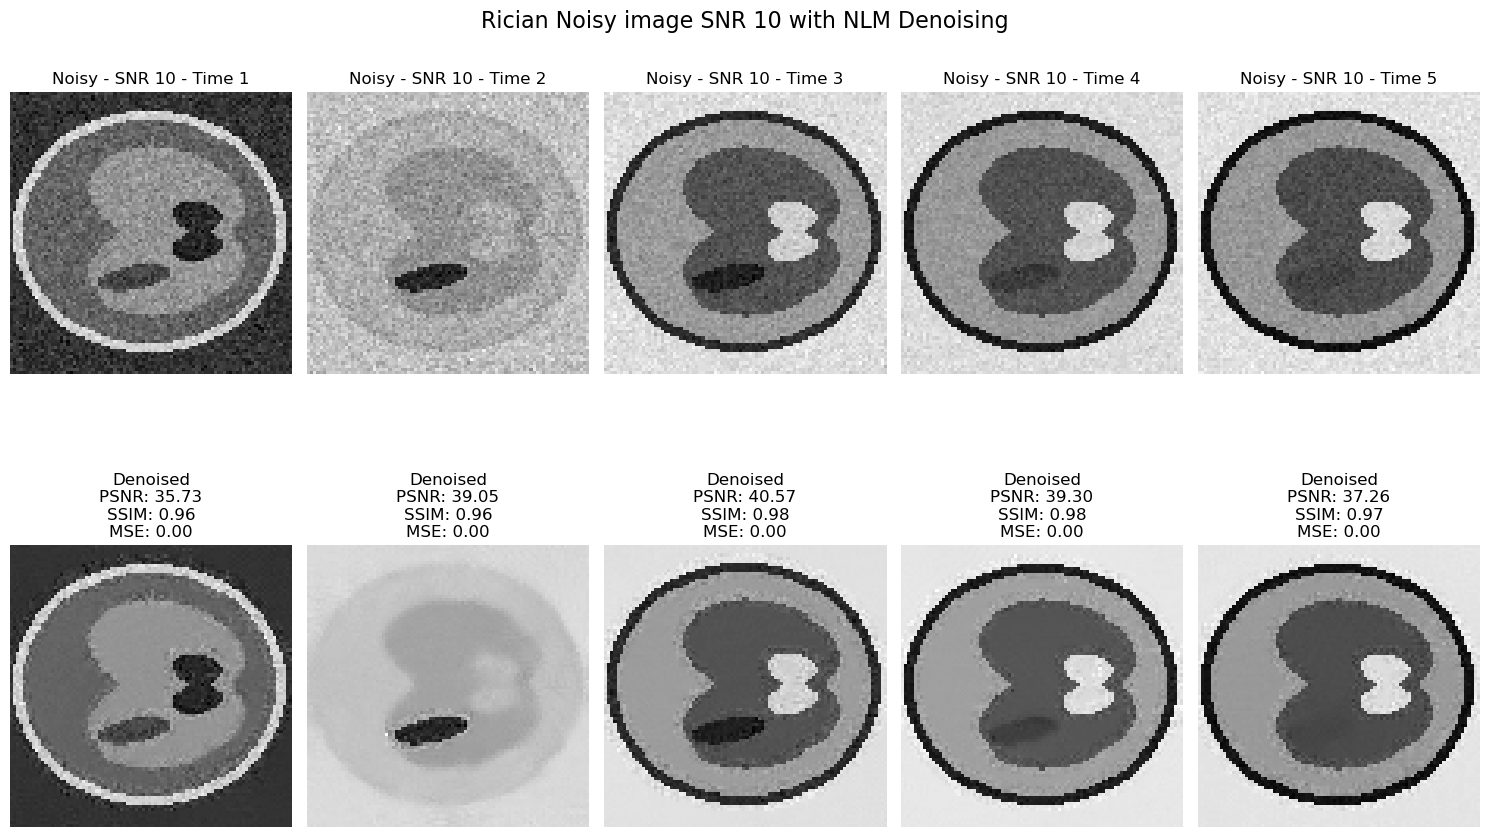

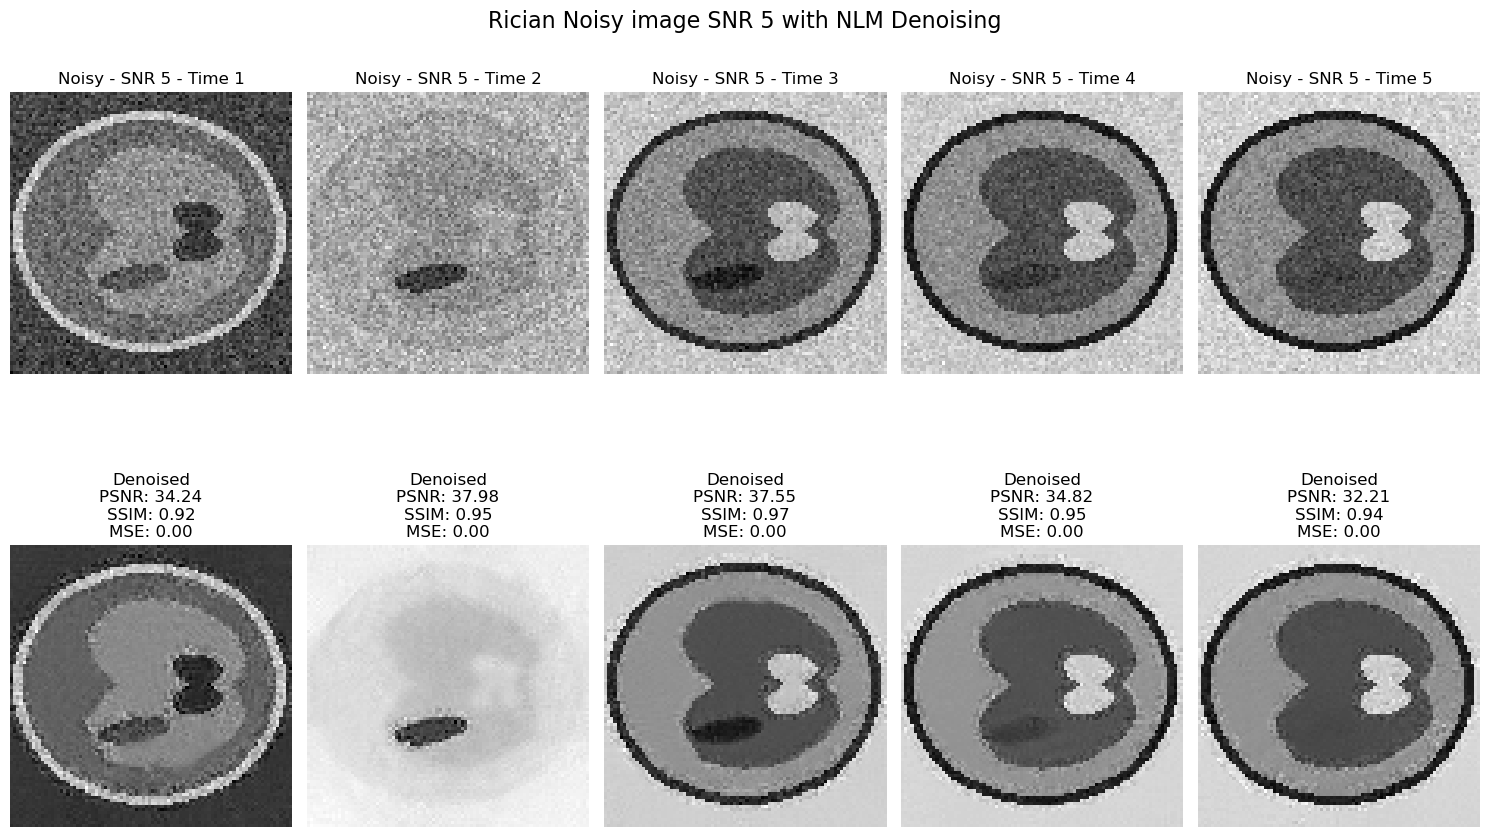

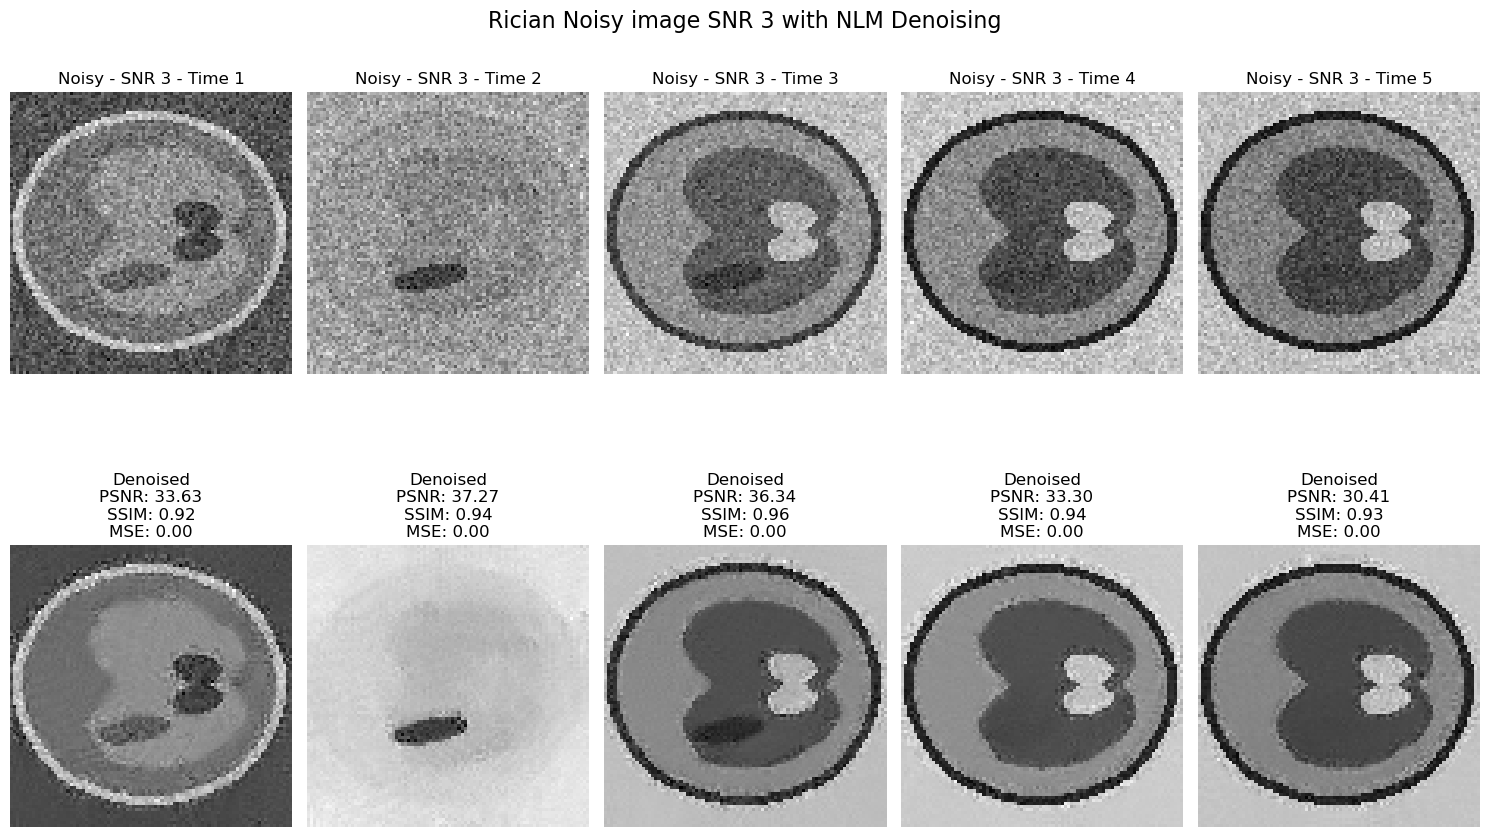

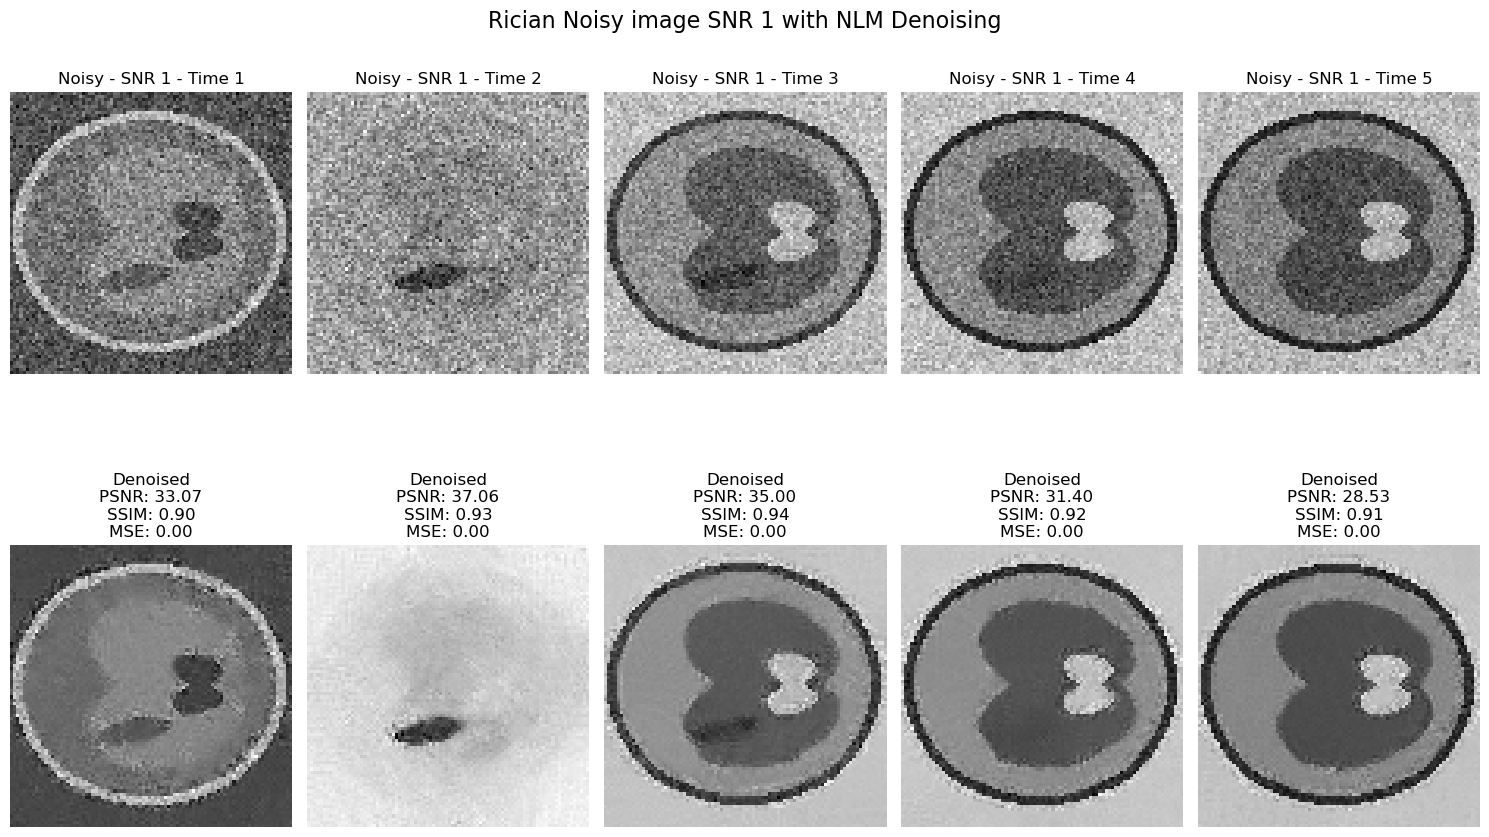

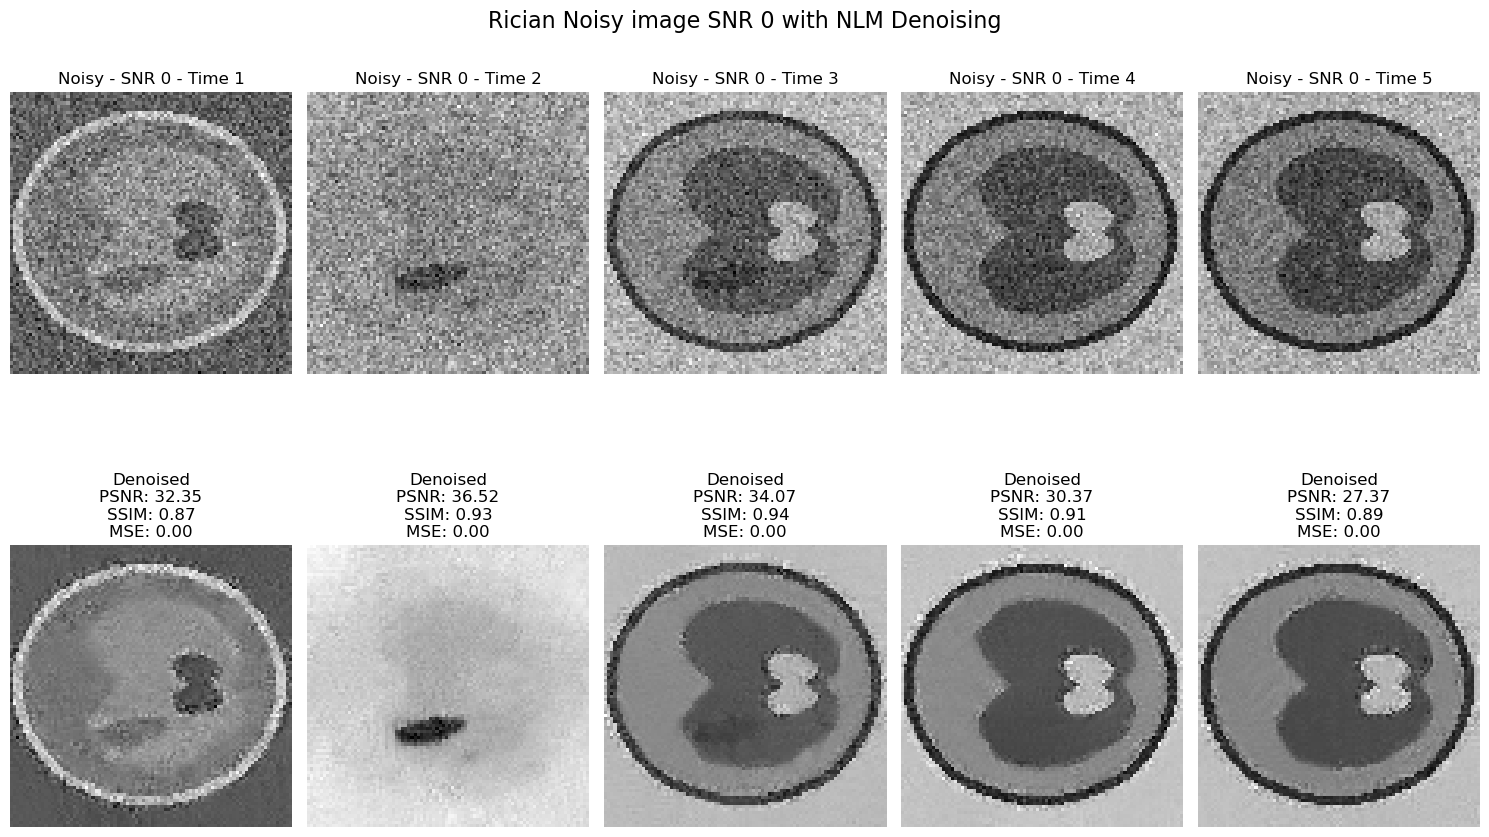

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.restoration import estimate_sigma, denoise_nl_means
from skimage.filters import threshold_otsu
from skimage.segmentation import clear_border
from skimage.measure import label, regionprops
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import mean_squared_error as mse
from scipy.stats import entropy as scipy_entropy
from skimage.filters import laplace
from skimage.color import rgb2gray
from skimage.filters import sobel
import seaborn as sns
import scipy.io
import scipy.io


# Define the specific SNRs to display
snrs = [10, 5, 3, 1, 0]  

def create_background_mask(image_gray):
    # Use Otsu's method to automatically determine a threshold for binarization
    thresh = threshold_otsu(image_gray)

    # Binarize the image based on the determined threshold
    binary_image = image_gray <= thresh

    # Remove small objects and clear borders
    cleared_image = clear_border(binary_image)

    # Label connected components
    label_image = label(cleared_image)

    # Find properties of labeled regions
    regions = regionprops(label_image)

    # Find the largest region (assuming it's the background)
    largest_area = 0
    background_label = 0
    for region in regions:
        if region.area > largest_area:
            largest_area = region.area
            background_label = region.label

    # Create a mask for the background region
    background_mask = label_image == background_label

    return background_mask

def adjust_denoising_parameters(sigma_est):
    if sigma_est <= 15:
        return 0.6 * sigma_est, 7, 11  # h, patch_size, patch_distance
    elif sigma_est <= 30:
        return 0.9 * sigma_est, 5, 6
    elif sigma_est <= 50:
        return 0.2 * sigma_est, 9, 17
    else:
        return 0.4 * sigma_est, 11, 23



for snr in snrs:
 
    # Load the MAT file
    mat = scipy.io.loadmat(f'../../ImagesForExperimentation/SimulationMatlab/GroundTruth_gaussian_SNR{snr}.mat')
    mat_ground_truth = scipy.io.loadmat(f'../../ImagesForExperimentation/SimulationMatlab/GroundTruth.mat')

    ground_truth_data = mat_ground_truth['data']
    noisy_image_data = mat['data_rician']
    
  
    evol_time = noisy_image_data.shape[2]

    plt.figure(figsize=(15, 2 * evol_time)) 

    for j in range(evol_time):
        # Extract the noisy image for the jth evol-time.
        noisy_image = noisy_image_data[:, :, j].squeeze()
        ground_truth= ground_truth_data[:, :, j]
        
        
        # Check if the image has three channels (RGB), and convert to grayscale if so
        if noisy_image.ndim == 3 and noisy_image.shape[2] == 3:
            noisy_image_gray = noisy_image.mean(axis=2)
        else:
            # If the image is already grayscale or doesn't meet the RGB shape assumption
            noisy_image_gray = noisy_image

        # Estimate the noise standard deviation from the image
        sigma_est = np.mean(estimate_sigma(noisy_image))

        h, patch_size, patch_distance = adjust_denoising_parameters(sigma_est)

        # Create a mask to isolate the background
        background_mask = create_background_mask(noisy_image_gray)

        # Calculate the standard deviation of background pixels
        std_deviation = np.std(noisy_image_gray[background_mask])
        
        ground_truth_gray = rgb2gray(ground_truth)

 
        denoised_image = denoise_nl_means(noisy_image_gray, h=h, patch_size=patch_size,
                                          patch_distance=patch_distance)
        
        
 
      

        image_ssim = ssim(ground_truth_gray, denoised_image, data_range=1.0)
        image_psnr = psnr(ground_truth_gray, denoised_image)
        image_mse = mse(ground_truth_gray, denoised_image)
       

        plt.subplot(2, evol_time, j + 1)
        plt.imshow(noisy_image_gray, cmap='gray')
        plt.title(f'Noisy - SNR {snr} - Time {j+1}')
        plt.axis('off')

        plt.subplot(2, evol_time, evol_time + j + 1)
        plt.imshow(denoised_image, cmap='gray')
        plt.title(f'Denoised\nPSNR: {image_psnr:.2f}\nSSIM: {image_ssim:.2f}\nMSE: {image_mse:.2f}')
        plt.axis('off')

    plt.subplots_adjust(wspace=0.1, hspace=0.1)  
    plt.tight_layout()  
    plt.suptitle(f'Rician Noisy image SNR {snr} with NLM Denoising', fontsize=16, y=0.95)
    plt.show()

  
  

